In [2]:
import numpy as np
from pprint import pprint
import sys, os
import pickle as pkl
import matplotlib.pyplot as plt


import matplotlib
font = {'family' : 'sans-serif',
        'sans-serif': 'Arial',
        'style': 'normal',
        'weight': 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)

from os.path import expanduser
home = expanduser("~")
model_home = os.path.join(home, 'src/model/ca3_biophysical/')
sys.path.append(os.path.join(home, 'src/model/ca3_biophysical/utils'))
sys.path.append(os.path.join(home, 'src/model/ca3_biophysical/cells'))
sys.path.append(os.path.join(home, 'bin/nrnpython3/lib/python'))


from SetupConnections import Arena, WiringDiagram
from NeuronCircuit import Circuit
from analysis_utils import baks, restore_weights, saved_weight_change, spike_bins
from plot_utils import plot_spikes, plot_spikes_with_density


%load_ext autoreload
%autoreload 2

NEURON: unable to open font "*helvetica-medium-r-normal*--14*", using "fixed"


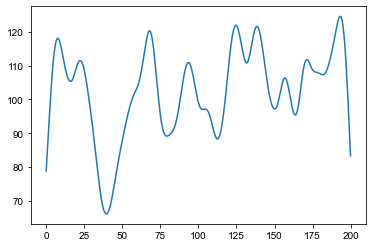

In [3]:

delay = 500.
dt = 0.1
params_path = os.path.join(model_home, 'params')
ar = Arena(os.path.join(params_path, 'arenaparams_ripple_lognormal.yaml'))
arena_map  = np.arange(0, 200,step=0.1)

ar.generate_population_firing_rates()
#ar.generate_cue_firing_rates('LEC', 1.0)
total_fr = None
for i in range(400):
    fr = ar.cell_information['MF']['cell info'][i]['firing rate']
    if i == 0:
        total_fr = np.copy(fr)
    else:
        total_fr += fr

plt.figure()
plt.plot(arena_map, total_fr)
plt.show();



In [186]:
ar.generate_spike_times('MF', dt=dt, delay=delay)
ar.generate_spike_times('MEC', dt=dt, delay=delay)
ar.generate_spike_times('LEC', dt=dt, delay=delay, cued=False)
ar.generate_spike_times('Background', dt=dt, delay=delay)


In [4]:
arena_size = ar.params['Arena']['arena size']
bin_size   = ar.params['Arena']['bin size']
mouse_speed = ar.params['Arena']['mouse speed']
nlaps       = ar.params['Arena']['lap information']['nlaps']

time_for_single_lap = arena_size / mouse_speed * 1000.
print(time_for_single_lap, nlaps)

6666.666666666667 4


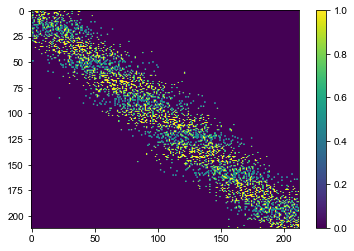

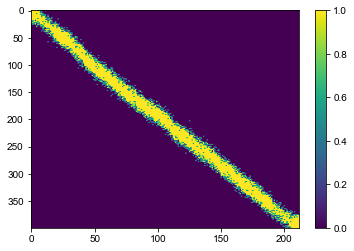

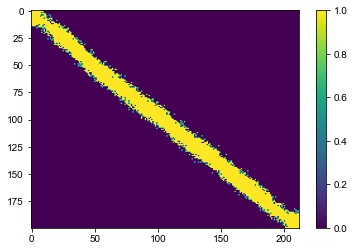

In [5]:
place_information = {'place ids': [0], 'place fracs': [0.80]}

#diagram = WiringDiagram('params/circuitparams_ripple_72522.yaml', place_information)
diagram = WiringDiagram(os.path.join(params_path, 'circuitparams_ripple.yaml'), place_information)

internal_kwargs = {}
internal_kwargs['place information'] = diagram.place_information
internal_kwargs['cue information'] = diagram.place_information
diagram.generate_internal_connectivity(**internal_kwargs)

external_kwargs = {}
external_kwargs['place information'] = diagram.place_information
external_kwargs['external place ids'] = [100, 101, 102]
external_kwargs['cue information'] = diagram.place_information
external_kwargs['external cue ids'] = [100, 101, 102]

diagram.generate_external_connectivity(ar.cell_information, **external_kwargs)
diagram.generate_septal_connectivity()

place_ids = diagram.place_information[0]['place']

plt.figure()
plt.imshow(diagram.internal_adj_matrices[0][0][place_ids,:][:,place_ids], aspect='auto')
plt.colorbar()
plt.show()


plt.figure()
plt.imshow(diagram.external_adj_matrices[100][0][:,place_ids], aspect='auto')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(diagram.external_adj_matrices[101][0][:,place_ids], aspect='auto')
plt.colorbar()
plt.show()



In [6]:
def get_spike_times(population2info_dict):
    spike_times = []
    gids = np.sort(list(population2info_dict.keys()))
    for gid in gids:
        spike_times.append(population2info_dict[gid]['spike times'])
    return spike_times

mf_spike_times  = get_spike_times(ar.cell_information['MF']['cell info'])
mec_spike_times = get_spike_times(ar.cell_information['MEC']['cell info'])
lec_spike_times = get_spike_times(ar.cell_information['LEC']['cell info'])
bk_spike_times  = get_spike_times(ar.cell_information['Background']['cell info'])

KeyError: 'spike times'

In [7]:
cue_cells = diagram.place_information[0]['not place']
place_cells = diagram.place_information[0]['place']
print(cue_cells)
print(place_cells)

[2, 3, 9, 12, 16, 22, 23, 24, 40, 41, 44, 47, 52, 55, 57, 58, 59, 67, 68, 79, 88, 90, 94, 106, 107, 132, 134, 137, 139, 141, 152, 158, 174, 182, 183, 185, 196, 198, 203, 214, 220, 223, 226, 234, 237, 243, 250, 254]
[0, 1, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 17, 18, 19, 20, 21, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 42, 43, 45, 46, 48, 49, 50, 51, 53, 54, 56, 60, 61, 62, 63, 64, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 89, 91, 92, 93, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 133, 135, 136, 138, 140, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 153, 154, 155, 156, 157, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 175, 176, 177, 178, 179, 180, 181, 184, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 197, 199, 200, 201, 202, 204, 205, 206, 207, 208, 209, 210, 211, 212

186


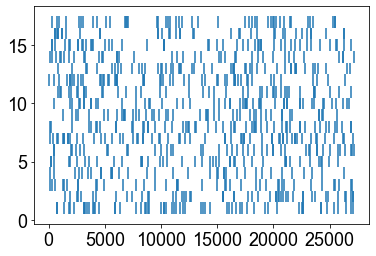

In [191]:

ctype_offset = diagram.external_information['Background']['ctype offset']
for z in place_cells[150:151]:
    print(z)

    plt.figure()
    i = 0
    src_ids = np.nonzero(diagram.external_adj_matrices[103][0][z])[0]

    for src_id in src_ids:
        src_gid = src_id + ctype_offset
        src_gid_spikes = bk_spike_times[src_gid]
        plt.vlines(list(src_gid_spikes), i+0.5, i+1.5)
        i += 1
 #   plt.xlim([0,7500])
 

52
55


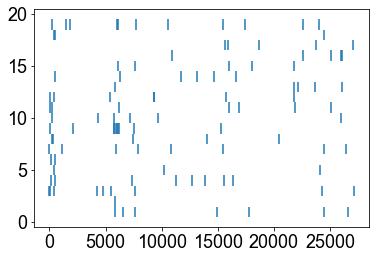

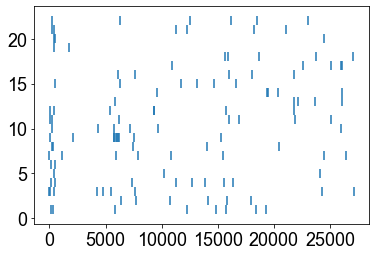

In [192]:
cue_cells = diagram.place_information[0]['not place']
ctype_offset = diagram.external_information['MF']['ctype offset']
for z in cue_cells[12:14]:
    print(z)

    plt.figure()
    i = 0
    src_ids = np.nonzero(diagram.external_adj_matrices[100][0][z])[0]

    for src_id in src_ids:
        src_gid = src_id + ctype_offset
        src_gid_spikes = mf_spike_times[src_gid]
        plt.vlines(list(src_gid_spikes), i+0.5, i+1.5)
        i += 1
 #   plt.xlim([0,7500])
 

2
3


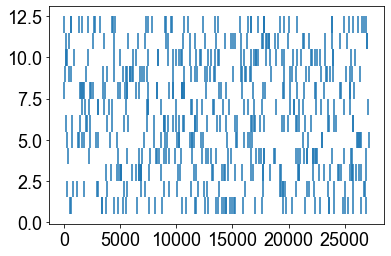

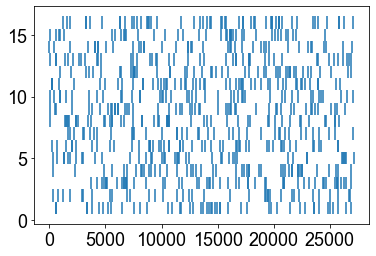

In [193]:
cue_cells = diagram.place_information[0]['not place']
ctype_offset = diagram.external_information['MEC']['ctype offset']
for z in cue_cells[:2]:
    print(z)

    plt.figure()
    i = 0
    src_ids = np.nonzero(diagram.external_adj_matrices[101][0][z])[0]

    for src_id in src_ids:
        src_gid = src_id + ctype_offset
        src_gid_spikes = bk_spike_times[src_gid]
        plt.vlines(list(src_gid_spikes), i+0.5, i+1.5)
        i += 1
 #   plt.xlim([0,7500])
 

2
3


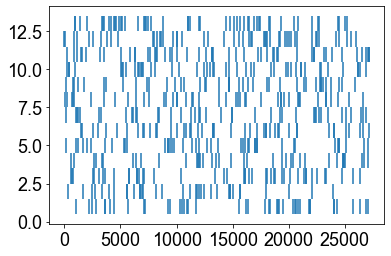

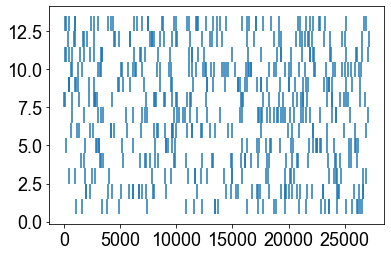

In [194]:
cue_cells = diagram.place_information[0]['not place']
ctype_offset = diagram.external_information['LEC']['ctype offset']
for z in cue_cells[:2]:
    print(z)

    plt.figure()
    i = 0
    src_ids = np.nonzero(diagram.external_adj_matrices[102][0][z])[0]

    for src_id in src_ids:
        src_gid = src_id + ctype_offset
        src_gid_spikes = bk_spike_times[src_gid]
        plt.vlines(list(src_gid_spikes), i+0.5, i+1.5)
        i += 1
 #   plt.xlim([0,7500])
 

In [195]:
# this assumes plasticity is off

#model_filepath =  'models/48-trained-cue-on-inhplas-off-lecplas-off-15iter.npz' # no inh plasticity
#model_filepath =  'models/48-trained-cue-on-inhplas-ie-lecplas-off-20iter.npz' # inh plasticity
#model_filepath =  'models/48-trained-cue-on-inhplas-ei-lecplas-off-15iter.npz' # bad inh plasticity

# best ee ie: 'models/72722-cue-ee-ie-nlaps-15-dt-zerodot1-scale-2-v1.npz'
# best ee: 'models/9622-cue-ee-nlaps-15-dt-zerodot1-scale-2-v4.npz'
# best ee ei: 'models/9622-cue-ee-ei-nlaps-15-dt-zerodot1-scale-2-v1.npz'

model_filepath = 'models/72722-cue-ee-ie-nlaps-15-dt-zerodot1-scale-2-v1.npz'
weights_filepath = '../params/1104_grads_stdp_mf_input_lognormal-cue-ee-ei-nlaps-20-dt-zerodot1-scale-2-v1.npz'


#79-V1 is best so far
saved_weights = restore_weights(diagram, weights_filepath)



15834


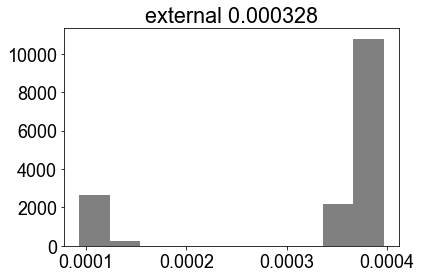

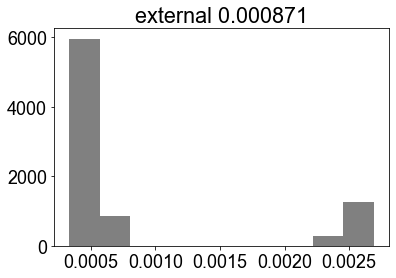

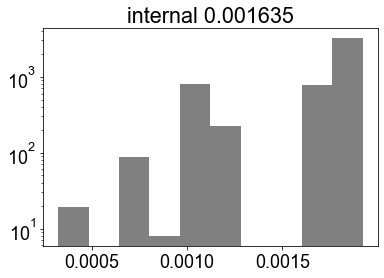

In [196]:
from analysis_utils import external_weight_change, internal_weight_change


external_before, external_after, external_pchange = saved_weight_change(saved_weights, 100, 0)
print(len(external_before))

plt.figure()
plt.hist([external_before], color=['gray'])
plt.title('external %f' % (np.mean(external_before)))
plt.show()


#

external_before, external_after, external_pchange = saved_weight_change(saved_weights, 102, 0)

plt.figure()
plt.hist([external_before], color=['gray'])
plt.title('external %f' % (np.mean(external_before)))
plt.show()


#

internal_before, internal_after, internal_pchange = saved_weight_change(saved_weights, 0, 0, valid_gids=np.arange(130))


plt.figure()
plt.hist([internal_before], color=['gray'])
plt.title('internal %f' % (np.mean(internal_before)))
plt.yscale('log')
plt.show()


In [197]:
place_cells = diagram.place_information[0]['place']
non_place_cells = diagram.place_information[0]['not place']
scale = 2

pvbc_to_place_weights = []
for pgid in place_cells:
    cell_info = circuit.neurons[0][pgid].internal_netcons
    for (presynaptic_gid, nc, _) in cell_info:
        if presynaptic_gid >= 130*scale and presynaptic_gid < 145*scale:
            weight = nc[0].weight[0] #+ nc[0].weight[1]
            pvbc_to_place_weights.append(weight)

pvbc_to_notplace_weights = []
for pgid in non_place_cells:
    cell_info = circuit.neurons[0][pgid].internal_netcons
    for (presynaptic_gid, nc, _) in cell_info:
        if presynaptic_gid >= 130*scale and presynaptic_gid < 145*scale:
            weight = nc[0].weight[0] #+ nc[0].weight[1]
            pvbc_to_notplace_weights.append(weight)      
        

print(len(pvbc_to_place_weights) + len(pvbc_to_notplace_weights))
        
        
fig = plt.figure(dpi=300, figsize=(4.5, 4.0))
ax = fig.gca()
plt.hist([pvbc_to_place_weights, pvbc_to_notplace_weights], color=[(49/255.,126/255.,194/255.), (231/255.,135/225.,43/255.)], 
         density=True, edgecolor='k', linewidth=2.0)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0.0)

    
print('place median', np.median(pvbc_to_place_weights))
print('nonplace median', np.median(pvbc_to_notplace_weights))

 
print('place mean', np.mean(pvbc_to_place_weights))
print('nonplace mean', np.mean(pvbc_to_notplace_weights))

from scipy.stats import ttest_ind, mannwhitneyu
t, p = ttest_ind(pvbc_to_place_weights, pvbc_to_notplace_weights)
print(t, p)

u, pmw = mannwhitneyu(pvbc_to_place_weights, pvbc_to_notplace_weights, alternative='less')
print('mwu', u, pmw)


NameError: name 'circuit' is not defined

In [198]:
exc_v_vecs = { int(k): v for k,v in np.load("../data/v_vecs_ripple_1104_grads_stdp_ie_mf_mec_lec_input_lognormal-nlaps-4.npz").items() }
dt = 0.025
t_end = exc_v_vecs[0].shape[0] * dt
t_vec = np.arange(0., t_end, dt)

27166.65


[]

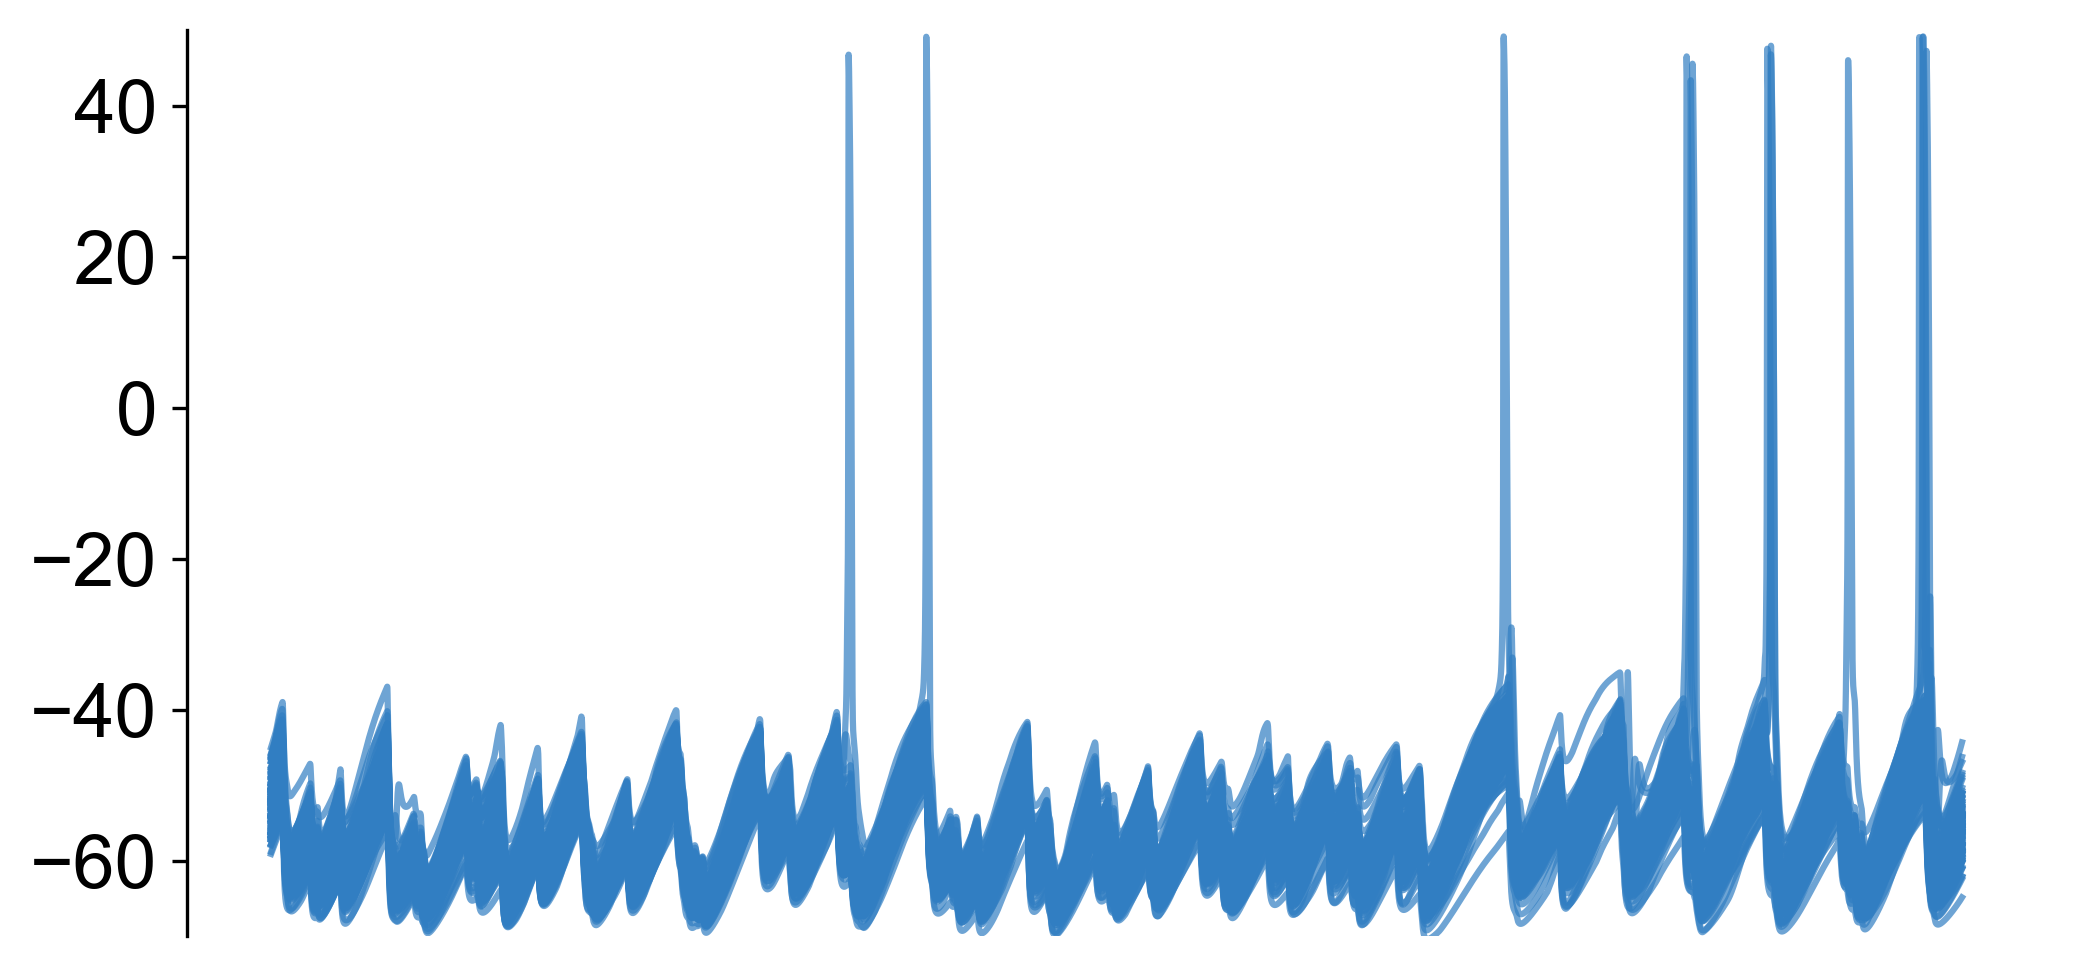

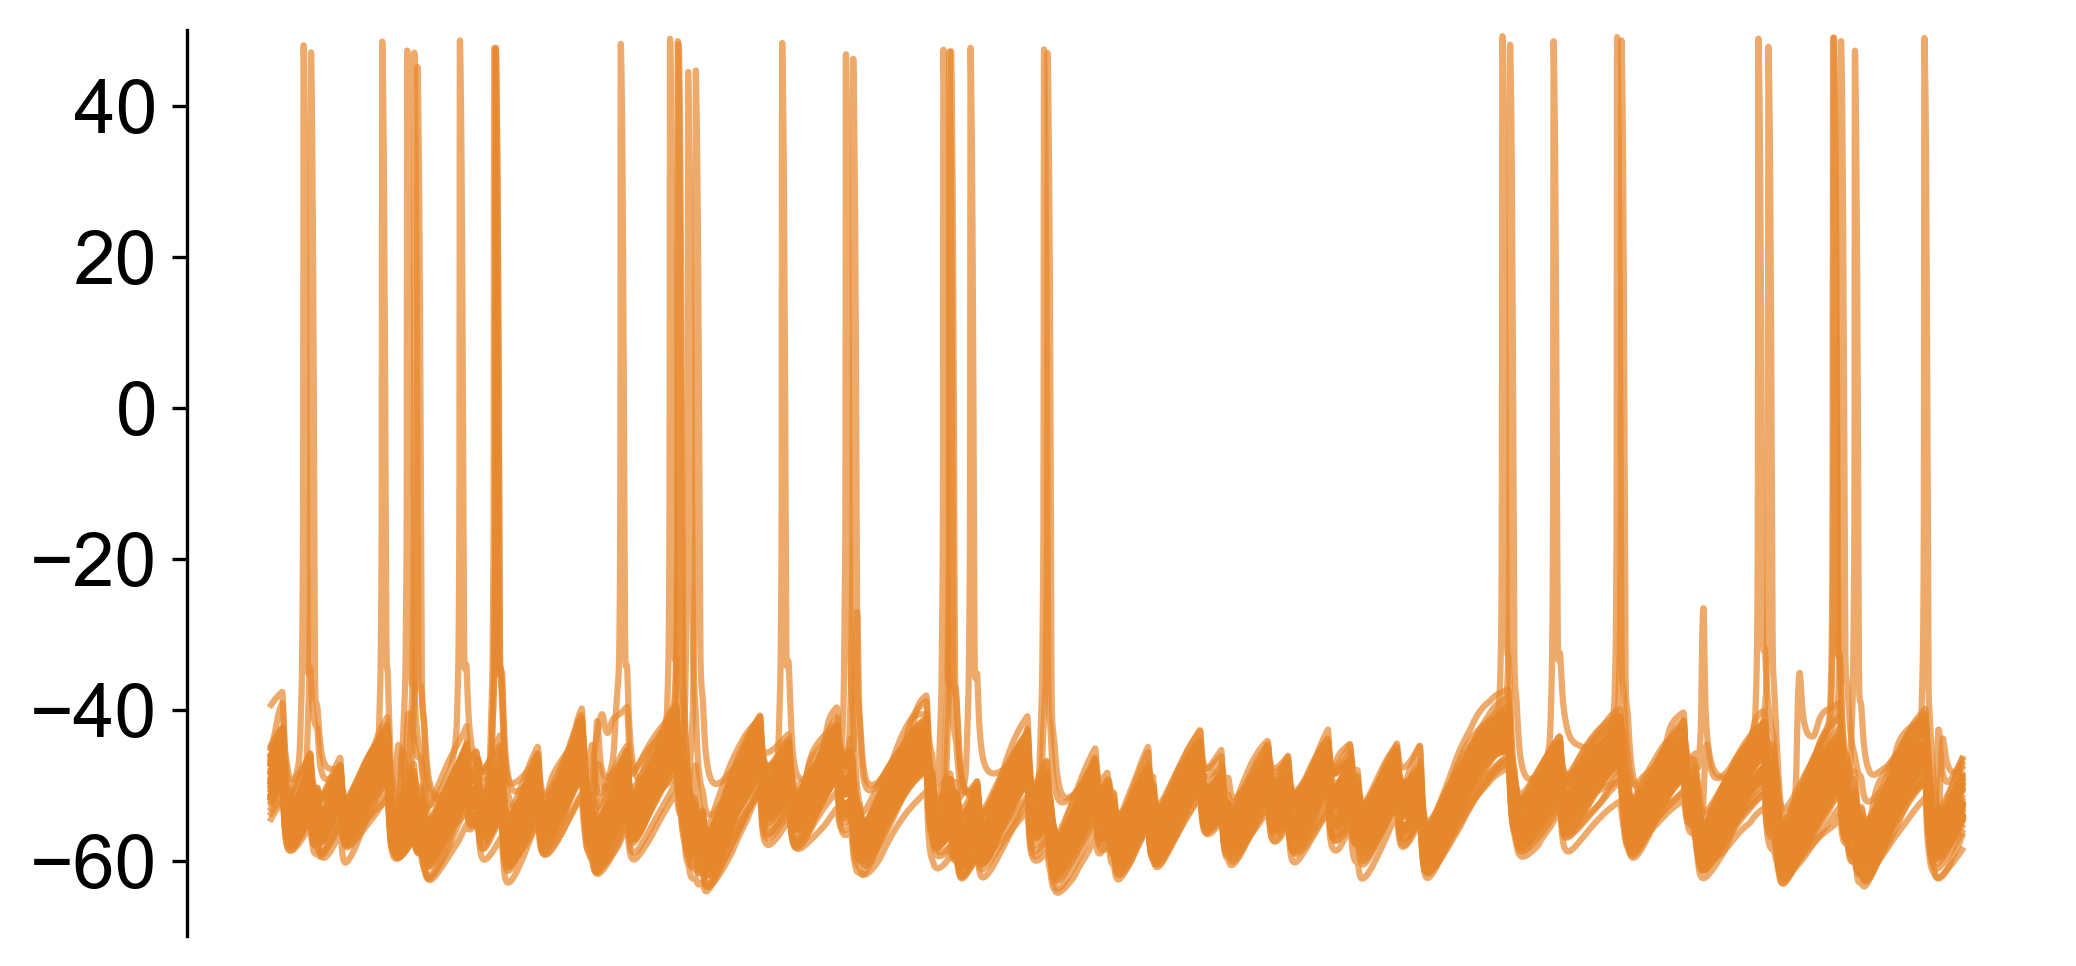

In [199]:
from analysis_utils import butter_bandpass_filter
from scipy.signal import welch, spectrogram
from copy import deepcopy

print(np.max(t_vec))
s = np.where(t_vec > time_for_single_lap*2.5)[0][0]
e = np.where(t_vec < time_for_single_lap*2.6)[0][-1]

#s = np.where(t_vec > 500)[0][0]
#e = np.where(t_vec < 15000+500)[0][-1]

place_gids = list(sorted(diagram.place_information[0]['place']))

place_exc_v_vecs_array = np.vstack([exc_v_vecs[gid][s:e] for gid in place_gids[50:]]).T

fig = plt.figure(dpi=300,figsize=(8,4))
ax  = fig.gca()
plt.plot(np.divide(t_vec[s:e], 1000.),
         place_exc_v_vecs_array,
         color=(49/255.,126/255.,194/255.), alpha=0.7)
plt.ylim([-70, 50])
for axis in ['top','right', 'bottom']:
    ax.spines[axis].set_linewidth(0.0)
ax.set_xticks([])
    
    
cue_lst = deepcopy(diagram.place_information[0]['not place'])

cue_exc_v_vecs_array = np.vstack([exc_v_vecs[gid][s:e] for gid in cue_lst]).T

fig = plt.figure(dpi=300,figsize=(8,4))
ax  = fig.gca()
plt.plot(np.divide(t_vec[s:e], 1000.), 
         np.vstack([exc_v_vecs[gid][s:e] for gid in cue_lst]).T,
         color=(231/255.,135/255.,43/255.), alpha=0.7)
plt.ylim([-70, 50])
for axis in ['top','right', 'bottom']:
    ax.spines[axis].set_linewidth(0.0)
ax.set_xticks([])

/mnt/d/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


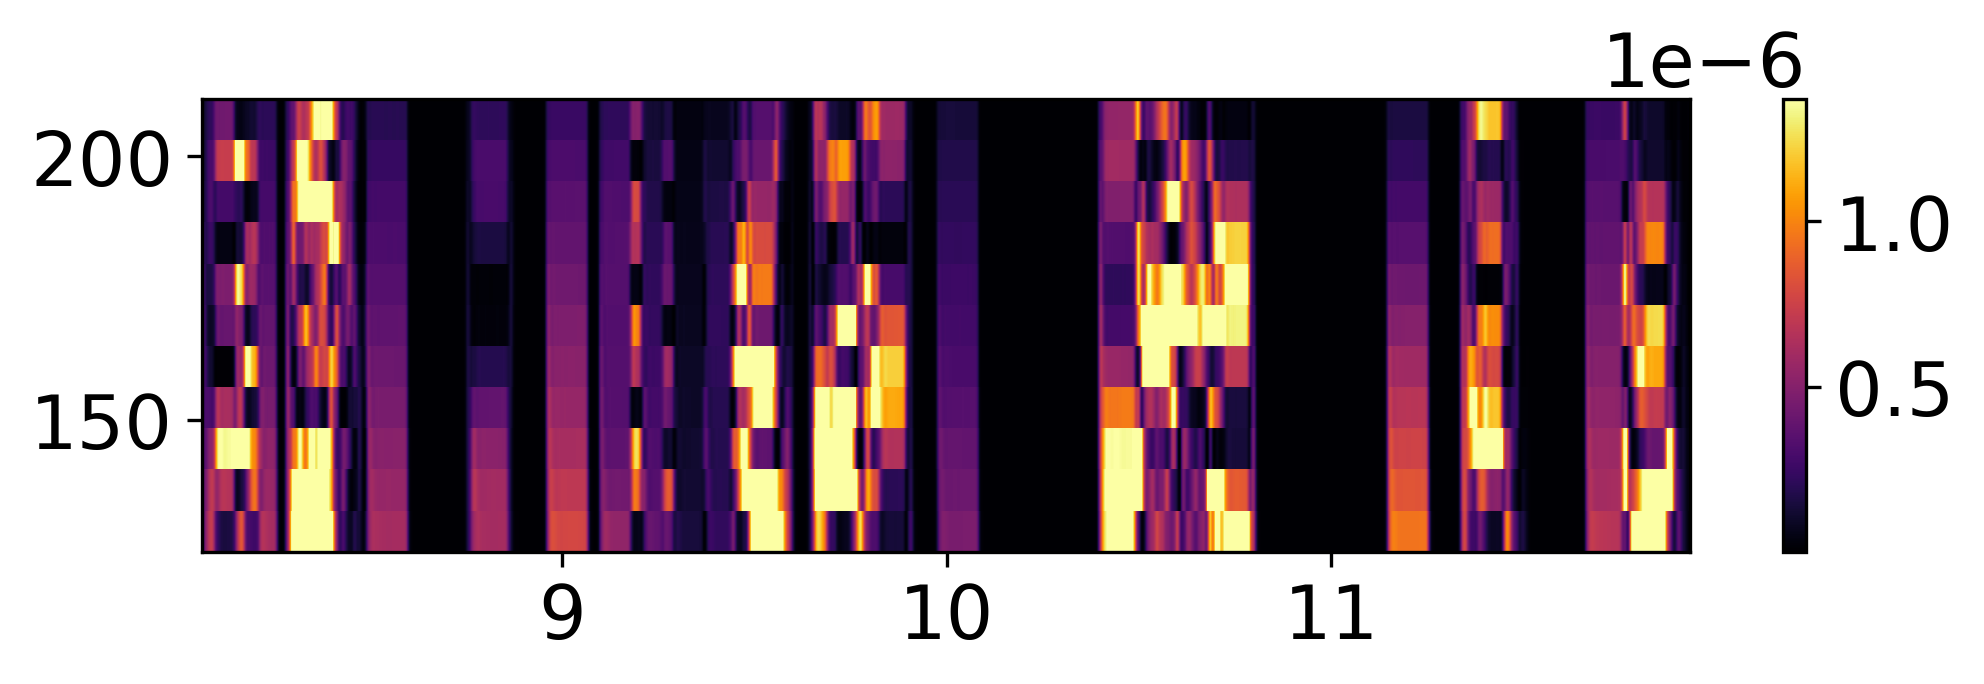

In [151]:

lfp = circuit.lfp
lfp_np = np.asarray([np.asarray(l, dtype='float32') for l in lfp], dtype='float32')
lfp_mean = lfp_np.mean(axis=0)
lfp_filtered = butter_bandpass_filter(lfp_mean, 100.0, 220.0, 2000., order=3)



start = np.where(np.asarray(t_vec) > 8000+500)[0][0]
end   = np.where(np.asarray(t_vec) < 12000+500)[0][-1]

ns = 256
lfp_f, lfp_t, lfp_S = spectrogram(lfp_filtered[start:end], fs=2000., nfft=ns, nperseg=ns, noverlap=ns-1)
lfp_t += 8.0
fs, fe = np.where(lfp_f >= 120.0)[0][0], np.where(lfp_f <= 220)[0][-1]
lfp_S_reduced = lfp_S[fs:fe,:]
minn = np.percentile(lfp_S_reduced, 5.)
maxx = np.percentile(lfp_S_reduced, 95.)

plt.figure(dpi=300, figsize=(8,2))
plt.pcolormesh(lfp_t, lfp_f[fs:fe], lfp_S_reduced, vmin=minn, vmax=maxx, cmap='inferno')
plt.colorbar()
#plt.xticks([])
plt.show()


398


(-19.85, 416.85, -0.05214949444992256, 0.051085510255522826)

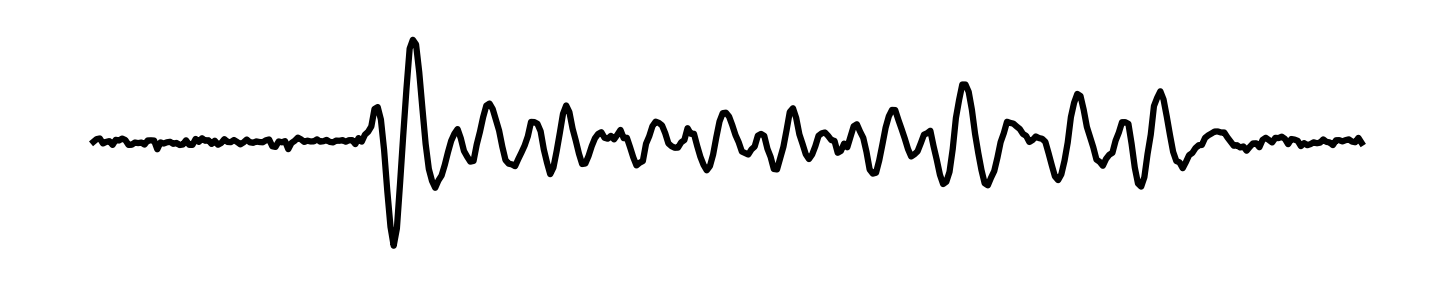

In [153]:

start = np.where(np.asarray(t_vec) > 10500+500)[0][0]
end   = np.where(np.asarray(t_vec) < 10700+500)[0][-1]
noise_add = np.random.normal(0,1.0e-3,size=end-start)
print(len(noise_add))
fig = plt.figure(figsize=(6,1.0), dpi=300)
ax  = fig.gca()
plt.plot(lfp_filtered[start:end] + noise_add, color='k')
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0.0)
plt.axis('off')

9998


(-499.85, 10496.85, -0.05956965174547215, 0.0651948383287005)

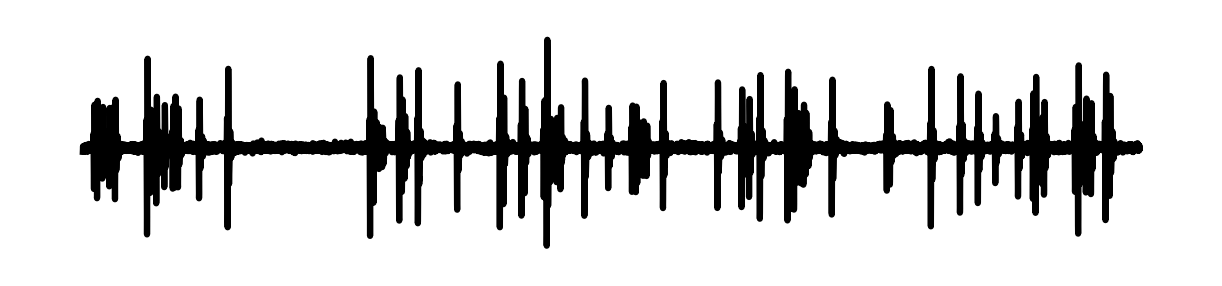

In [61]:

start = np.where(np.asarray(t_vec) > 5000+500)[0][0]
end   = np.where(np.asarray(t_vec) < 10000+500)[0][-1]
noise_add = np.random.normal(0,1.0e-3,size=end-start)
print(len(noise_add))
fig = plt.figure(figsize=(5,1.0), dpi=300)
ax  = fig.gca()
plt.plot(lfp_filtered[start:end] + noise_add, color='k')
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0.0)
plt.axis('off')

In [13]:
cell_spike_times = np.load("../data/cell_spikes_ripple_updown_state_1023_segs_stdp_ie_mf_mec_lec_input_uniform-nlaps-3.npz")
cell_spike_times = { int(gid): v for gid, v in cell_spike_times.items() }


place-cue corr PearsonRResult(statistic=-0.5342104183276062, pvalue=8.304794831553817e-08)
place-pvbc corr PearsonRResult(statistic=0.9078378607080113, pvalue=3.261488029665938e-34)
pvbc-cue corr PearsonRResult(statistic=-0.3268283746044547, pvalue=0.0018841790804129852)


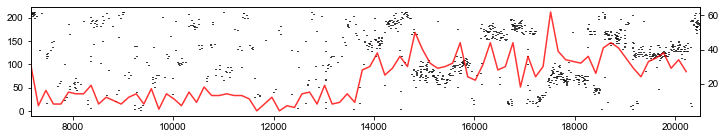

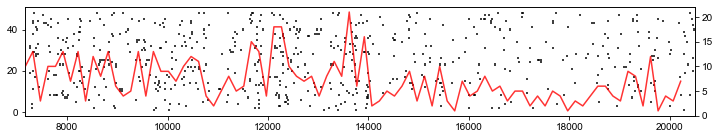

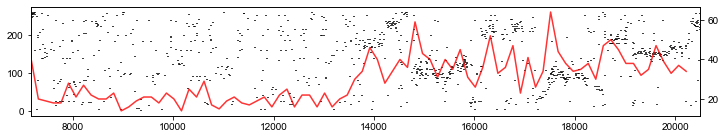

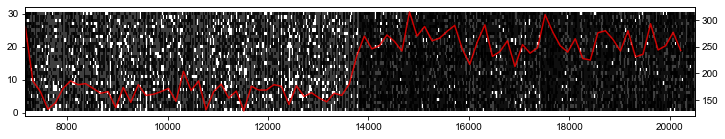

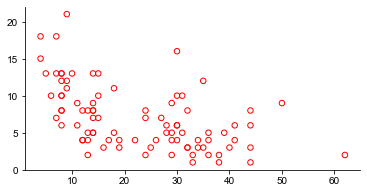

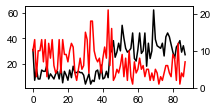

r,p -0.5763043908271387 4.218874766663308e-09 88


In [15]:

start  = time_for_single_lap * 1. + 500
finish = time_for_single_lap * 3. + 500

nspikes_place = plot_spikes_with_density(cell_spike_times, 'PYR place', start, finish, diagram.place_information[0]['place'])
nspikes_cue   = plot_spikes_with_density(cell_spike_times, 'PYR cue', start, finish, diagram.place_information[0]['not place'])
nspikes_total = plot_spikes_with_density(cell_spike_times, 'PYR all', start, finish, np.arange(130*2))


nspikes_pvbc  = plot_spikes_with_density(cell_spike_times, 'PVBC', start, finish, gids=list(range(260,290)))
# plot_spikes(c, 2, 'AAC', start, finish)
# plot_spikes(c, 3, 'BiS', start, finish)
# plot_spikes(c, 4, 'OLM', start, finish)
# plot_spikes(c, 5, 'ISCCR', start, finish)
#plot_spikes(6, 'ISCCK', start, finish)
from scipy.stats import pearsonr, spearmanr
print('place-cue corr', pearsonr(nspikes_place, nspikes_cue))
print('place-pvbc corr', pearsonr(nspikes_place, nspikes_pvbc))
print('pvbc-cue corr', pearsonr(nspikes_pvbc, nspikes_cue))

#(6,3)
fig = plt.figure(figsize=(6,3))
ax  = fig.gca()
plt.scatter(nspikes_place, nspikes_cue, facecolor='none', edgecolor='red',s=30)
# plt.xlabel('number place cells spikes')
# plt.ylabel('number cue cells spikes')
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0.0)
plt.show()

fig, ax = plt.subplots(figsize=(3,1.5))
ax.plot(nspikes_place, color='k')
ax2 = ax.twinx()
ax2.plot(nspikes_cue, color='r')
plt.show()

from scipy.stats import pearsonr, spearmanr
r, p = spearmanr(nspikes_place, nspikes_cue)
print('r,p', r, p, len(nspikes_place))

88
(88, 2)


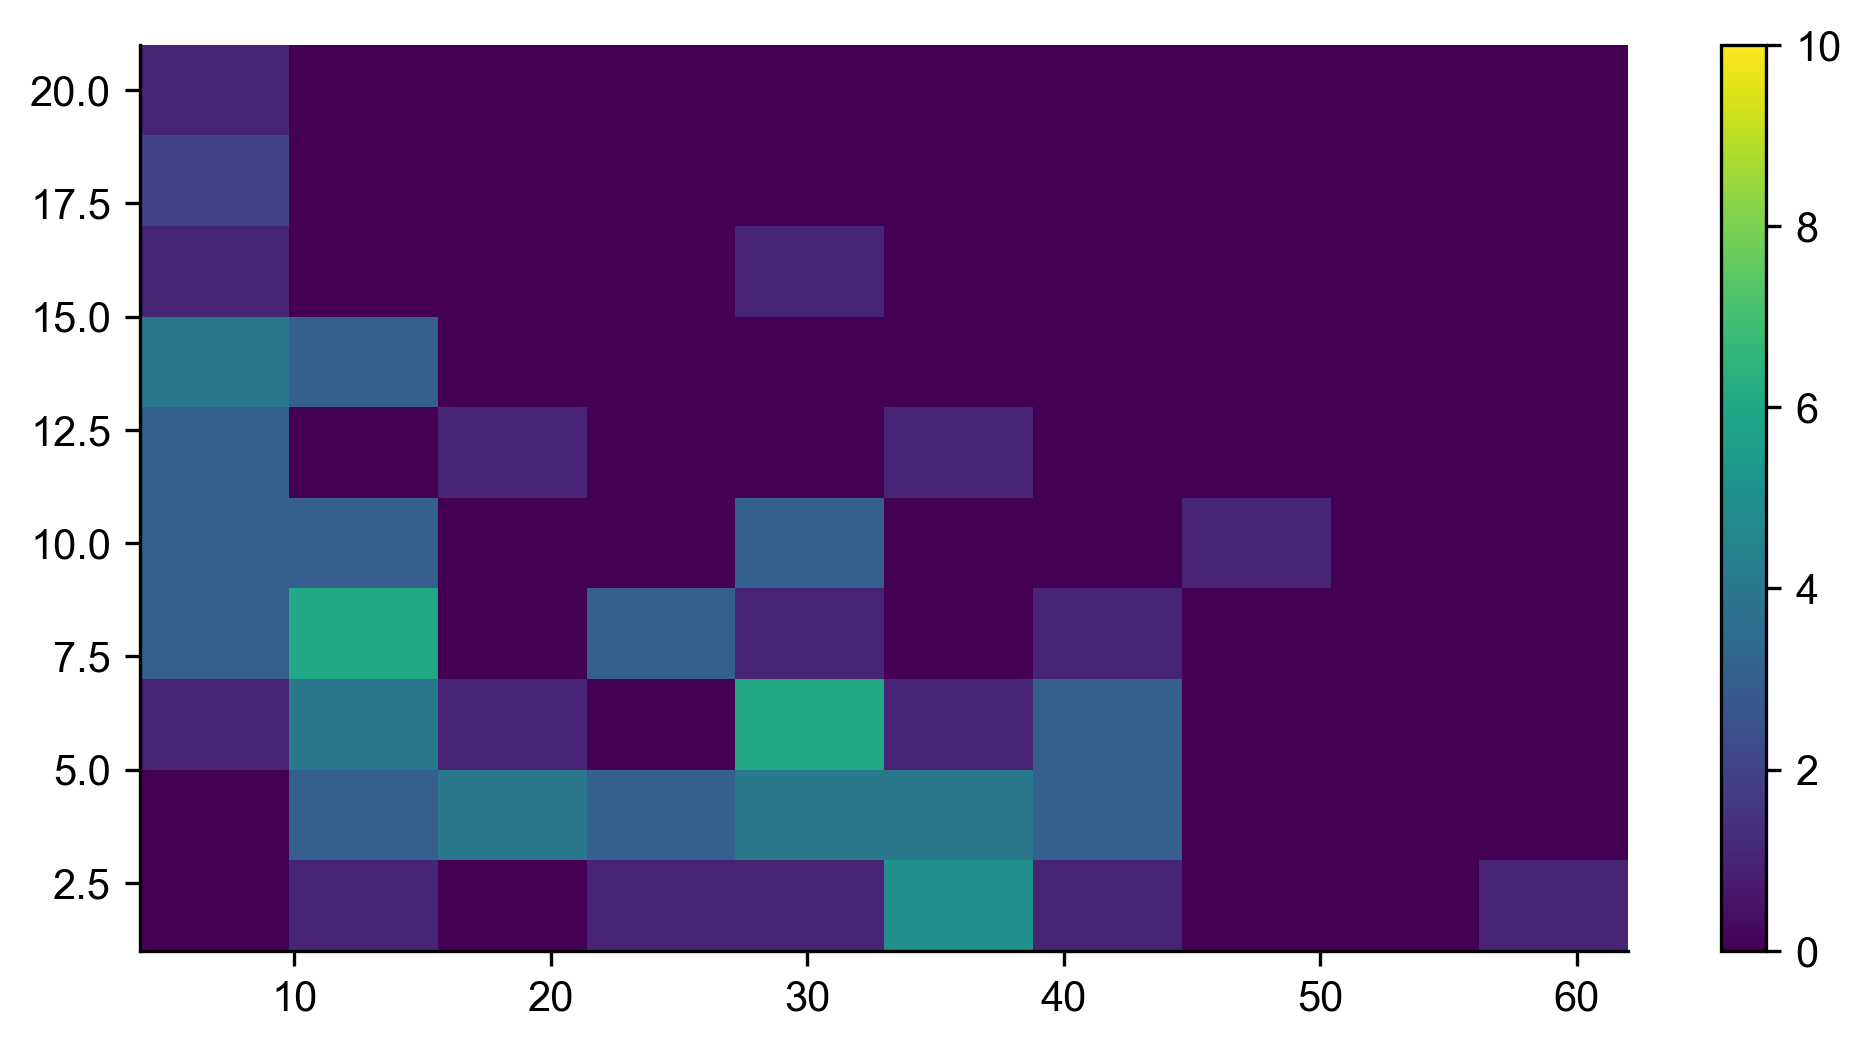

In [16]:
import seaborn as sns
import pandas as pd

#sns.kdeplot(data = df, x="x", y="y", cmap="Reds", shade=True)
#df = pd.DataFrame({'cue': np.asarray(nspikes_cue), 'place': np.asarray(nspikes_place)})

print(len(nspikes_place))
nspikes_combined = list(zip(nspikes_place, nspikes_cue))
nspikes_combined_refined = []
for (a,b) in nspikes_combined:
    if (a == 0 and b == 0): continue
    nspikes_combined_refined.append([a,b])
nspikes_combined_refined = np.asarray(nspikes_combined_refined)
print(nspikes_combined_refined.shape)

fig = plt.figure(figsize=(8,4), dpi=300)
ax  = fig.gca()
plt.hist2d(nspikes_combined_refined[:,0], nspikes_combined_refined[:,1], vmin=0, vmax=10)
plt.colorbar()
#plt.scatter(nspikes_place, nspikes_cue, facecolor='none', edgecolor='gray',s=10)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0.0)
plt.show()




#(16,4)

# print(len(nspikes_place))
# max_place = max(nspikes_place)
# max_cue   = max(nspikes_cue)
# heatmap_matrix = np.zeros((max_place+1, max_cue+1))
# for (a,b) in list(zip(nspikes_place, nspikes_cue)):
#     if a == 0 and b == 0: continue
#     if heatmap_matrix[a,b] >= 10: continue
#     heatmap_matrix[a,b] += 1
    
# from copy import deepcopy
# cleaned_matrix = deepcopy(heatmap_matrix)
# cleaned_matrix[heatmap_matrix==0] = None
    
# fig = plt.figure(dpi=300, figsize=(14,3.0))
# plt.imshow(cleaned_matrix.T, aspect='auto', extent=(0,max_place+1,0,max_cue+1))
# plt.colorbar()
# # plt.xlabel('number place cells spikes')
# # plt.ylabel('number cue cells spikes')
# plt.show()


[0, 1, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 17, 18, 19, 20, 21, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 42, 43, 45, 46, 48, 49, 50, 51, 53, 54, 56, 60, 61, 62, 63, 64, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 89, 91, 92, 93, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 133, 135, 136, 138, 140, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 153, 154, 155, 156, 157, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 175, 176, 177, 178, 179, 180, 181, 184, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 197, 199, 200, 201, 202, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 215, 216, 217, 218, 219, 221, 222, 224, 225, 227, 228, 229, 230, 231, 232, 233, 235, 236, 238, 239, 240, 241, 242, 244, 245, 246, 247, 248, 249, 251, 252, 253, 255, 256, 257, 258, 259]
[2, 3, 9, 12, 16, 22, 2

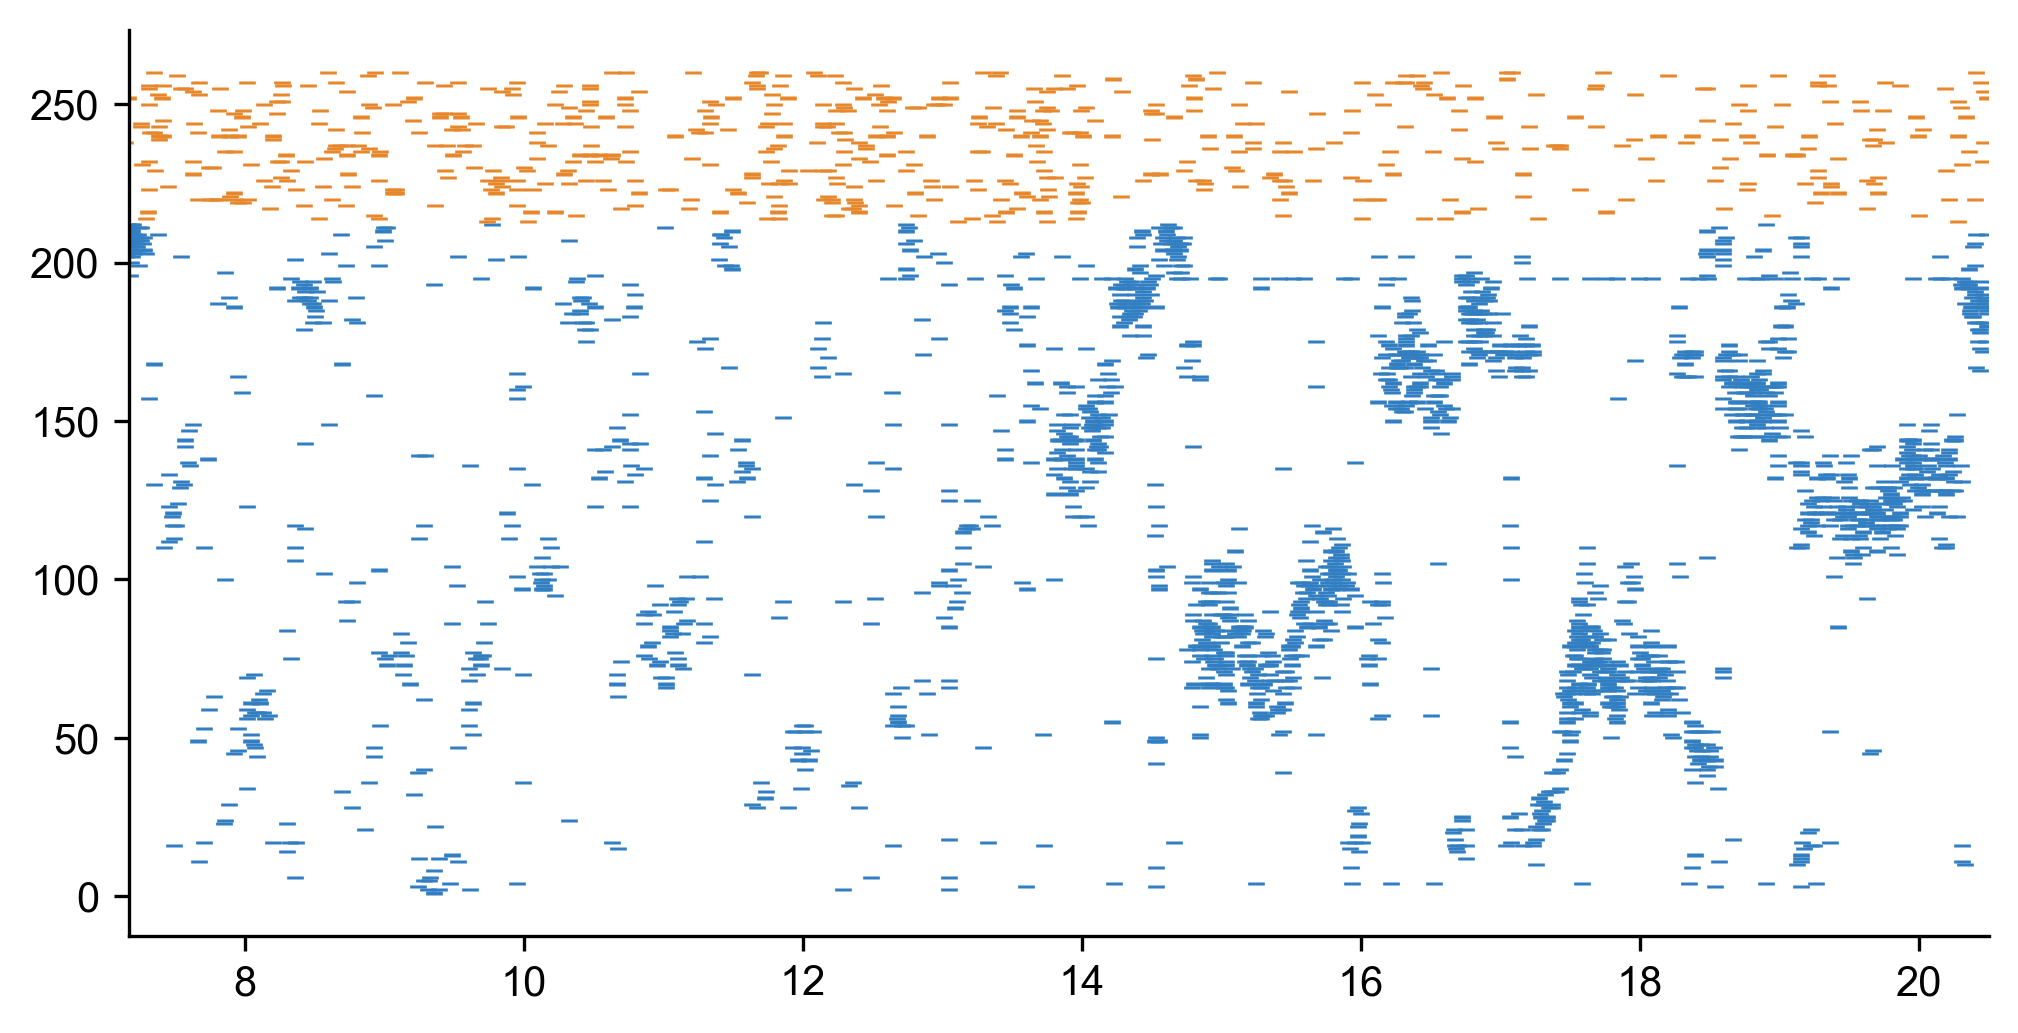

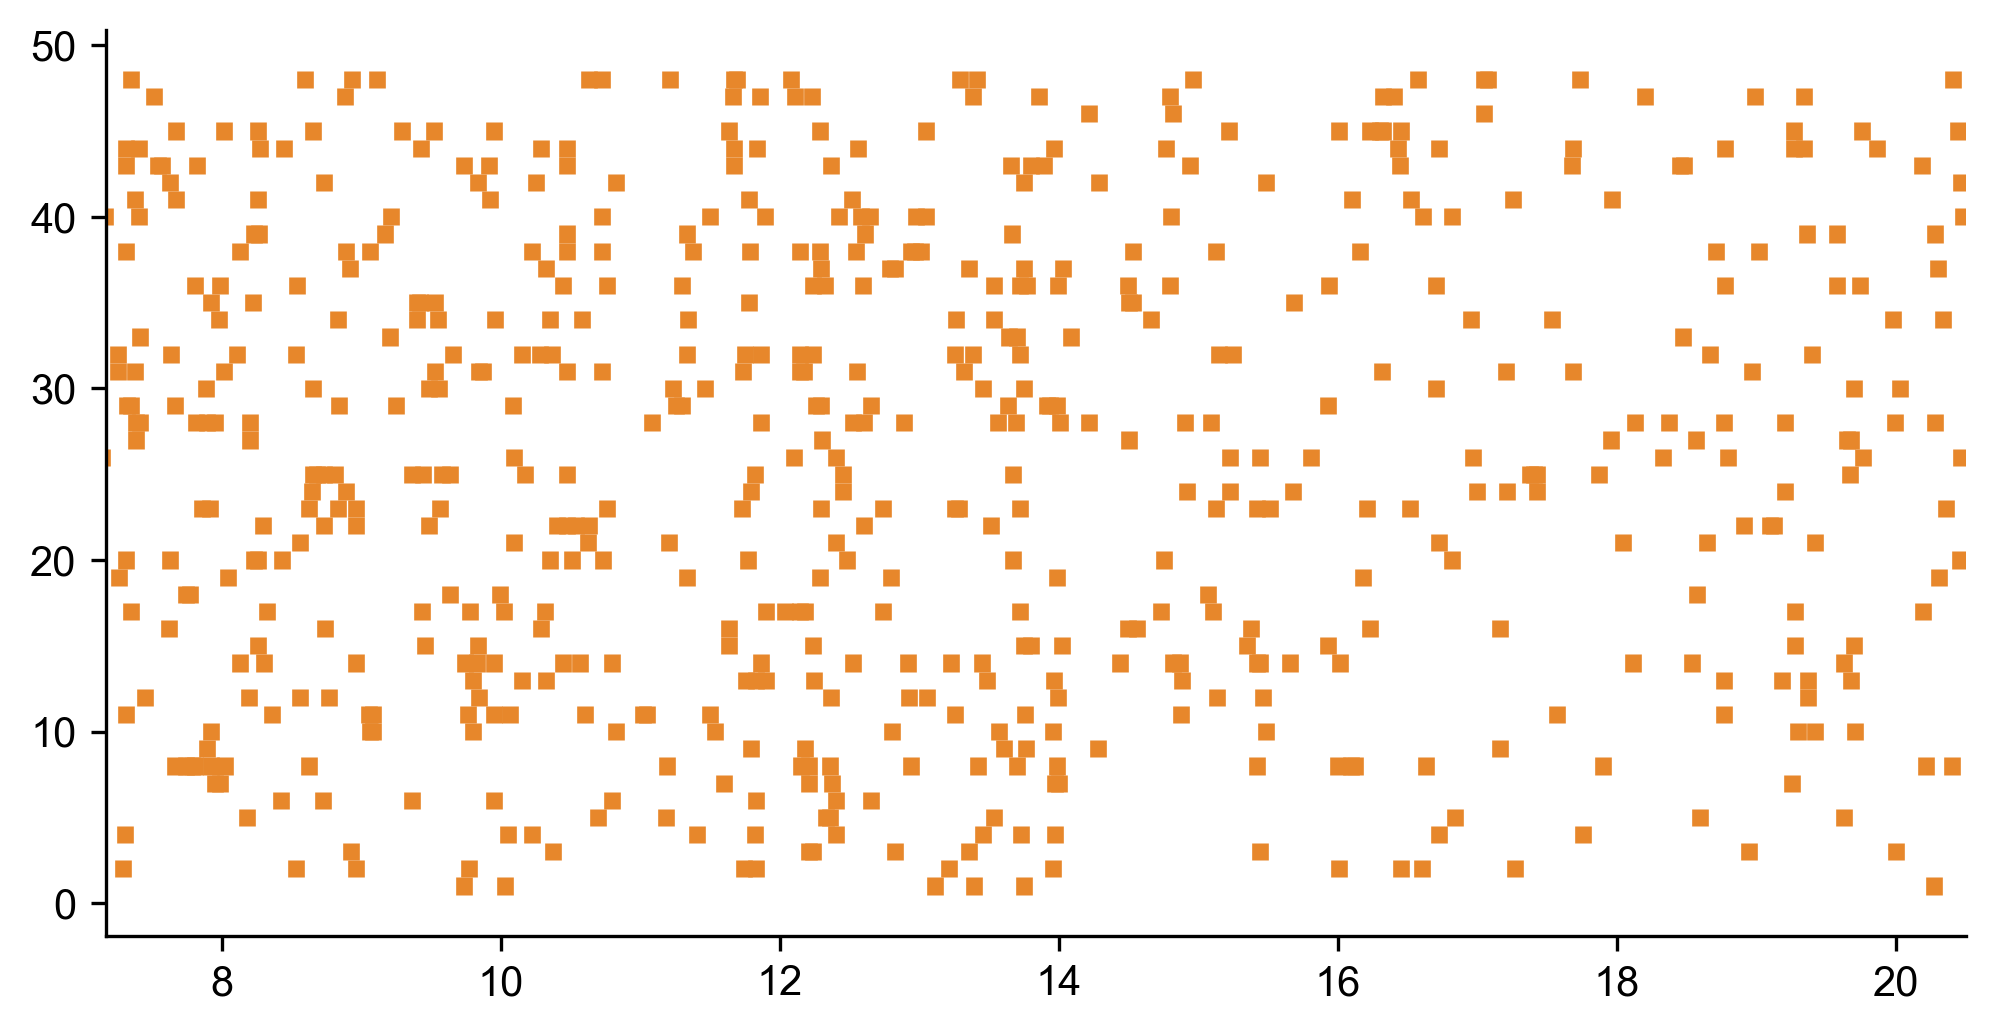

In [18]:
def plot_spikes(spike_times, title, start, finish, gids=None, **kwargs):
    place_ids = kwargs.get('place ids', [])
    cue_ids   = kwargs.get('cue ids', [])
    
    if gids is not None:
        temp_spike_times = []
        for i in gids:
            temp_spike_times.append(np.divide(spike_times[i], 1000.))
        spike_times = temp_spike_times
        
    frs = []
    fig, ax = plt.subplots(dpi=300, figsize=(8,4))
    count = 0
    for (i,pid) in enumerate(place_ids):
        sts = np.asarray(spike_times[pid])
        ax.vlines(np.asarray(sts), i+0.5, i+1.5, color=kwargs['place colors'], linewidth=4)
        sts_chop = sts[np.where( (sts>=start) & (sts<=finish)) [0]]
        frs.append(float(len(sts_chop)) / (finish-start) * 1000.)
        count += 1
    for (i,cid) in enumerate(cue_ids):
        sts = np.asarray(spike_times[cid])
        ax.vlines(np.asarray(sts), i+count+0.5, i+count+1.5, color=kwargs['cue colors'], linewidth=4)
        sts_chop = sts[np.where( (sts>=start) & (sts<=finish)) [0]]
        frs.append(float(len(sts_chop)) / (finish-start) * 1000.)     
        
    
    ax.set_xlim([start/1000., finish/1000.])
    for axis in ['top','right']:
        ax.spines[axis].set_linewidth(0.0)  
    #plt.ylim([25, 60])

place_ids = diagram.place_information[0]['place']
place_colors = (49/255., 126/255., 194/255.)
cue_ids = diagram.place_information[0]['not place']
cue_colors = (231/255., 135/255., 43/255.)
print(sorted(place_ids))
print(sorted(cue_ids))
print(len(cue_ids))


kwargs = {'place ids': place_ids, 'place colors': place_colors, 'cue ids': cue_ids, 'cue colors': cue_colors} 
start  = time_for_single_lap * 1. + 500
finish = time_for_single_lap * 3.+ 500


print(finish-start)

scale = 2
#start = 11500
#finish = 12500

#start = 18500
#finish = 20100

plot_spikes(cell_spike_times, 'PYR all', start, finish, np.arange(130*scale), **kwargs)

kwargs = {'cue ids': cue_ids, 'cue colors': cue_colors} 
plot_spikes(cell_spike_times, 'PYR cue', start, finish, np.arange(130*scale), **kwargs)

[0, 1, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 17, 18, 19, 20, 21, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 42, 43, 45, 46, 48, 49, 50, 51, 53, 54, 56, 60, 61, 62, 63, 64, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 89, 91, 92, 93, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 133, 135, 136, 138, 140, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 153, 154, 155, 156, 157, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 175, 176, 177, 178, 179, 180, 181, 184, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 197, 199, 200, 201, 202, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 215, 216, 217, 218, 219, 221, 222, 224, 225, 227, 228, 229, 230, 231, 232, 233, 235, 236, 238, 239, 240, 241, 242, 244, 245, 246, 247, 248, 249, 251, 252, 253, 255, 256, 257, 258, 259]
20000.0


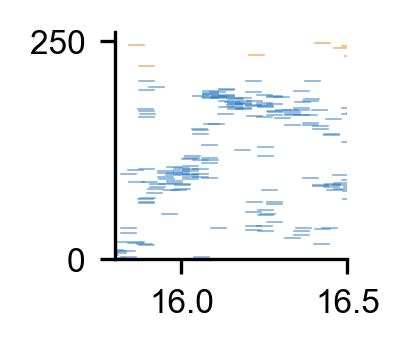

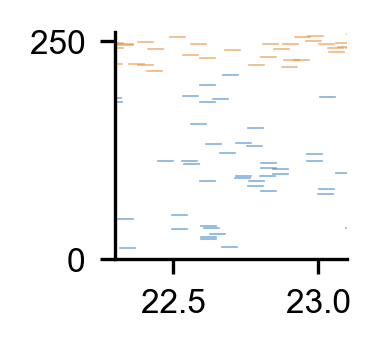

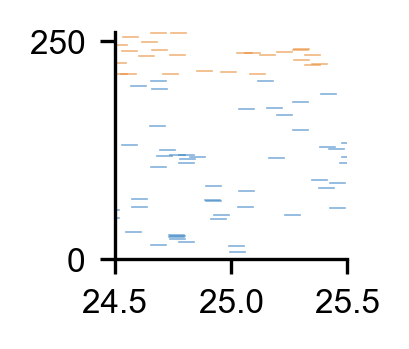

In [244]:
def plot_spikes(spike_times, title, start, finish, gids=None, **kwargs):
    place_ids = kwargs['place ids']
    cue_ids   = kwargs['cue ids']
    
    if gids is not None:
        temp_spike_times = []
        for i in gids:
            temp_spike_times.append(np.divide(spike_times[i], 1000.))
        spike_times = temp_spike_times
        
    frs = []
    #fig, ax = plt.subplots(dpi=300, figsize=(8,4))
    fig, ax = plt.subplots(dpi=300, figsize=(1,1))
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(8)
    count = 0
    for (i,pid) in enumerate(place_ids):
        sts = np.asarray(spike_times[pid])
        ax.vlines(np.asarray(sts), i+0.5, i+1.5, color=kwargs['place colors'], linewidth=4)
        sts_chop = sts[np.where( (sts>=start) & (sts<=finish)) [0]]
        frs.append(float(len(sts_chop)) / (finish-start) * 1000.)
        count += 1
    for (i,cid) in enumerate(cue_ids):
        sts = np.asarray(spike_times[cid])
        ax.vlines(np.asarray(sts), i+count+0.5, i+count+1.5, color=kwargs['cue colors'], linewidth=4)
        sts_chop = sts[np.where( (sts>=start) & (sts<=finish)) [0]]
        frs.append(float(len(sts_chop)) / (finish-start) * 1000.)     
        
    
    ax.set_xlim([start/1000., finish/1000.])
    for axis in ['top','right']:
        ax.spines[axis].set_linewidth(0.0)  
    plt.ylim([0, 260])

place_ids = diagram.place_information[0]['place']
place_colors = (49/255., 126/255., 194/255.)
cue_ids = diagram.place_information[0]['not place']
cue_colors = (231/255., 135/255., 43/255.)
print(place_ids)


kwargs = {'place ids': place_ids, 'place colors': place_colors, 'cue ids': cue_ids, 'cue colors': cue_colors} 
start  = time_for_single_lap * 1 + 500
finish = time_for_single_lap * 4.+ 500
print(finish-start)

scale = 2
start = 15800
finish = 16500
plot_spikes(cell_spike_times, 'PYR all', start, finish, np.arange(130*scale), **kwargs)
start = 22300
finish = 23100
plot_spikes(cell_spike_times, 'PYR all', start, finish, np.arange(130*scale), **kwargs)
start = 24500
finish = 25500
plot_spikes(cell_spike_times, 'PYR all', start, finish, np.arange(130*scale), **kwargs)


In [76]:
all_exc_frs = []
all_exc_spikes = []
valid_gids = []
start_time = time_for_single_lap * 0 + 500
end_time   = time_for_single_lap * 1 + 500

for i in circuit.neurons[0].keys():
    exc_spikes = np.asarray(circuit.neurons[0][i].spike_times)

    time_idxs = np.where( (exc_spikes >= start_time) & (exc_spikes <= end_time))[0]
    exc_spikes = exc_spikes[time_idxs]
    all_exc_spikes.append(exc_spikes)
    step = 12.5 # ms
    estimated_times = np.arange(start_time, end_time, step=step)

    try:
        estimated_fr,_ = baks(exc_spikes/1000., estimated_times/1000., a=10.0) # 1.75?
        all_exc_frs.append(estimated_fr)
        valid_gids.append(i)
    except:
        continue
all_exc_frs = np.asarray(all_exc_frs, dtype='float32')

idx = 30
plt.figure()
plt.plot(estimated_times/1000*30. - start_time/1000*30, all_exc_frs[valid_gids[idx]])
plt.show()

fig, ax = plt.subplots()
ax.plot(estimated_times/step, all_exc_frs[idx])
ax2 = ax.twinx()
ax2.vlines(all_exc_spikes[valid_gids[idx]]/step, 0.5, 1.5)
ax2.set_ylim([0, 5])
ax2.set_yticks([])


NameError: name 'circuit' is not defined

In [164]:


valid_idxs = []
invalid_idxs = []
for i in range(len(all_exc_frs)):
    sl = all_exc_frs[i]
    if not np.all(sl < 10.0): valid_idxs.append(i)
    else: 
        invalid_idxs.append(i)
valid_exc_frs = all_exc_frs[valid_idxs,:] # flip a rooni
print(valid_idxs)

normed = []
for i in range(len(valid_exc_frs)):
    normed.append(valid_exc_frs[i] / valid_exc_frs[i].max())
normed = np.asarray(normed, dtype='float32')

whereismax = []
for i in range(len(normed)):
    sl = normed[i,:]
    whereismax.append(sl.argmax())
sorted_max = np.argsort(whereismax)

normed_sorted        = normed[sorted_max,:]
valid_exc_frs_sorted = valid_exc_frs[sorted_max,:]


plt.figure()
plt.imshow(normed_sorted, cmap='viridis', aspect='auto')
plt.colorbar()
plt.show()



# fig, ax = plt.subplots(5, 5, figsize=(12,8))
# for i in range(25):
#     xx = int(i/5)
#     yy = int(i%5)
#     ax[xx,yy].plot(estimated_times, normed_sorted[i])
#     ax[xx,yy].hlines(0.80, estimated_times[0], estimated_times[-1], linestyle='--')
#     ax[xx,yy].set_title(i)
    
ncrossed = []
for i in range(len(valid_exc_frs_sorted)):
    sl = normed_sorted[i]
    crossed = False
    ticks = 0
    for s in sl:
        if s > 0.80 and not crossed: 
            crossed = True
            ticks += 1
        if s <= 0.80 and crossed:
            crossed = False
    ncrossed.append(ticks)

ncrossed = np.asarray(ncrossed + [0 for _ in range(len(all_exc_frs) - len(valid_exc_frs))])
print(set(ncrossed))
plt.figure()
plt.hist(ncrossed, bins=[0,1,2,3,4,5], align='left', rwidth=0.65, 
         edgecolor='k', color='gray', linewidth=2)
plt.show()

spike_times = np.asarray(circuit.get_cell_spikes(0))[valid_gids]
valid_raster = []
for nid in np.asarray(valid_idxs)[sorted_max]:
    valid_raster.append(spike_times[nid])

plt.figure(figsize=(12,2))
for (i,sts) in enumerate(valid_raster):
    sts = np.asarray(sts)
    plt.vlines(np.asarray(sts), i+0.5, i+1.5)
#plt.xlim([start_time, end_time])
#plt.xlim([end_time, end_time+time_for_single_lap])
plt.show()


invalid_raster = []
for nid in invalid_idxs:
    invalid_raster.append(spike_times[nid])

plt.figure(figsize=(12,2))
for (i,sts) in enumerate(invalid_raster):
    sts = np.asarray(sts)
    plt.vlines(np.asarray(sts), i+0.5, i+1.5)
#plt.xlim([start_time, end_time])
#plt.xlim([end_time, end_time+time_for_single_lap])
plt.show()


NameError: name 'all_exc_frs' is not defined